# Train 3D network on Memento

In [34]:
# Imports
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
from cv2 import imread, resize
from scipy.stats import spearmanr
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D, Input, TimeDistributed
from keras.models import Model
from keras.utils import Sequence
import keras.backend as K
from keras.optimizers import Adam, SGD
from timeit import default_timer as timer
import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
import pickle
import json
from tqdm import tqdm_notebook as tqdm
import seaborn as sns

sys.path.append('../src/')
sys.path.append('../imgaug')
from generator import VideoSeqGenerator, preprocess_i3d_rgb
from vid_utils import load_video_opencv, plot_frames
from keras_training import MultiGPUCheckpoint
from memento_utils import step_decay, get_sample_weights, loss_alpha, loss_alpha_mse, RankCorr, get_ckpt_name, define_callbacks, freeze_unfreeze_net
from imgaug import augmenters as iaa
from imgaug import parameters as iap

import i3d_config as cfg
from keras_models import build_i3d_custom, build_model_multigpu

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
keras.__version__

'2.2.4'

In [36]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
print(os.environ['CUDA_VISIBLE_DEVICES'])

0


In [37]:
%%bash
nvidia-smi

Tue May 21 20:36:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   30C    P8     9W / 250W |  12194MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   30C    P8     9W / 250W |  11853MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Key vars

In [38]:
data_type = 'flow'
dataset = 'memento10k'
gpus = 1
resc = 1
use_sw = 1
bs = 8
do = 0.5
loss_type='alphamse'

# Fetch video names, alphas and memorability scores


In [48]:
if os.uname()[1] == 'visiongpu30':
    data_path = '../../../moments_raw/sources_numpy_256/' if data_type=='rgb' else '../../../moments_flow/sources_flow_down1_tvl1_skip1/'
    labels_path = '../memento10k_labels/'
    names_with_slash = False
    load_func = 'npy_'+data_type
else:
    data_path = '../../moments/10k_clean'
    labels_path = '../../moments/split'
    names_with_slash = True
    load_func = 'vids_opencv'

with open(os.path.join(labels_path, 'train_test_split_moments.pkl'), 'rb') as f:
    tt_s = pickle.load(f)
    
train_names=[]
val_names=[]


# Fetch scores from ground truth json file with a defined T
T =80
mem_scores_file = 'normalized_mem_scores_ma_T=%d.json' % T
alpha_file = 'alphas_ma_T=%d.json' % T

with open(os.path.join(labels_path, mem_scores_file)) as f:
    name_to_mem = json.load(f)
    
with open(os.path.join(labels_path, alpha_file)) as f:
    name_to_alpha = json.load(f)
    
# Getting dict in same format as vid names
name_to_mem_alpha={}

if names_with_slash:
    for n in tt_s[0]:
        cl = n.split('_')[0]
        cl = cl.replace('-','+')
        newn = cl+'/'+'_'.join(n.split('_')[1:])
        train_names.append(newn)

    for n in tt_s[1]:
        cl = n.split('_')[0]
        cl = cl.replace('-','+')
        newn = cl+'/'+'_'.join(n.split('_')[1:])
        val_names.append(newn)
        
    for k,v in name_to_mem.items():
        name_to_mem_alpha[k] = np.array([v, name_to_alpha[k]])
    
else:
    train_names = sorted([ n[:-4]+'.npy' for n in tt_s[0] ])
    val_names = sorted([ n[:-4]+'.npy' for n in tt_s[1] ])
    for k,v in name_to_mem.items():
        newk = k.replace('/','_').replace('+','-')[:-4]+'.npy' 
        name_to_mem_alpha[newk] = np.array([v, name_to_alpha[k]])
    
print('Loaded %d train videos and %d val videos\n' % (len(train_names), len(val_names)))


print(train_names[:5])
print(list(name_to_mem_alpha.keys())[:5])


# Check if all names are in dict
for tn in train_names:
    if tn not in name_to_mem_alpha.keys():
        print('Train vid not in dict:',tn)
        
for tn in val_names:
    if tn not in name_to_mem_alpha.keys():
        print('Val vid not in dict:',tn)


Loaded 7027 train videos and 1507 val videos

['adult-female-singing_peeks-www_k_to_keek_2Qwueab_25.npy', 'adult-female-singing_peeks-www_k_to_keek_2Xyqeab_3.npy', 'adult-female-singing_peeks-www_k_to_keek_2g4teab_28.npy', 'adult-female-singing_peeks-www_k_to_keek_EO30eab_19.npy', 'adult-female-singing_peeks-www_k_to_keek_J2Rveab_1.npy']
['rolling_flickr-0-7-0-1-1-7-8-1-4007011781_26.npy', 'singing_flickr-7-0-5-6-8-9-6-7-3770568967_46.npy', 'flying_flickr-0-4-0-4-6-6-0-7-5504046607_55.npy', 'working_flickr-8-5-8-2-1-3-0-6-17285821306_7.npy', 'skating_flickr-1-2-9-4-2-9-7-2-3612942972_7.npy']


In [49]:
print(spearmanr([p[0] for p in name_to_mem_alpha.values()], [p[1] for p in name_to_mem_alpha.values()]))

SpearmanrResult(correlation=0.529940536897832, pvalue=0.0)


## Get weights if needed

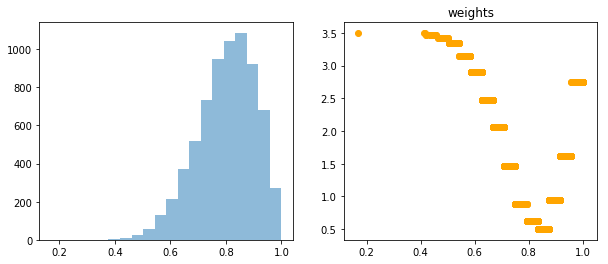

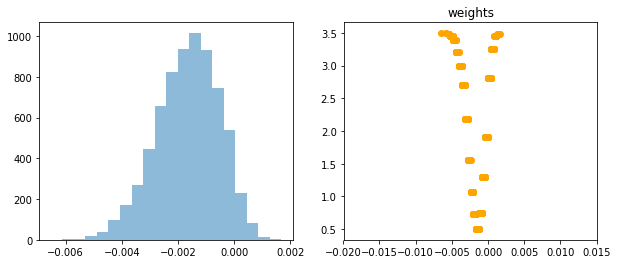

In [61]:
factor = 3
if use_sw:
    mem_weights = get_sample_weights([name_to_mem_alpha[n][0] for n in train_names], factor=factor)
    alpha_weights = get_sample_weights([name_to_mem_alpha[n][1] for n in train_names], factor=factor)
    
    sw=np.array(mem_weights)
else:
    sw=None

# Generator

In [52]:
# Instantiating generator
gen_train = VideoSeqGenerator(files=np.array(train_names),
                            batch_size=bs, 
                            dataset_path=data_path,
                            label_csv= None, 
                            augment= None, #['dropout', 'cutout'],
                            load_func=load_func,
                            load_labels_func='mem_alpha',
                            preprocess_func='fast_'+data_type,
                            remove_excess_files=False,
                            shuffle=True,
                            is_train=True,
                            verbose=True,
                            str2label_dict = name_to_mem_alpha,
                            sample_weights=sw)

gen_val = VideoSeqGenerator(files=np.array(val_names),
                            batch_size=bs, 
                            dataset_path=data_path,
                            label_csv=None,
                            augment=None,
                            load_func=load_func,
                            load_labels_func='mem_alpha',
                            preprocess_func='fast_'+data_type,
                            remove_excess_files=False,
                            shuffle=False,
                            is_train=False,
                            verbose=True,
                            str2label_dict = name_to_mem_alpha,
                            sample_weights=sw)

Caution: batch_size (8) is not multiple of given dataset length (7027). This can cause issues with multigpu training.
Calling VideoSeqGenerator. Batch size:  8 . Number of files received: 7027 . Augmentation:  None
Caution: batch_size (8) is not multiple of given dataset length (1507). This can cause issues with multigpu training.
Calling VideoSeqGenerator. Batch size:  8 . Number of files received: 1507 . Augmentation:  None


# Test Generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Total time on this batch: 0.8020320376381278  - it: 0 - idx: 375
Time loading: 0.7060477090999484
Time preprocessing: 0.09590685367584229
Time augmenting: 7.747486233711243e-05


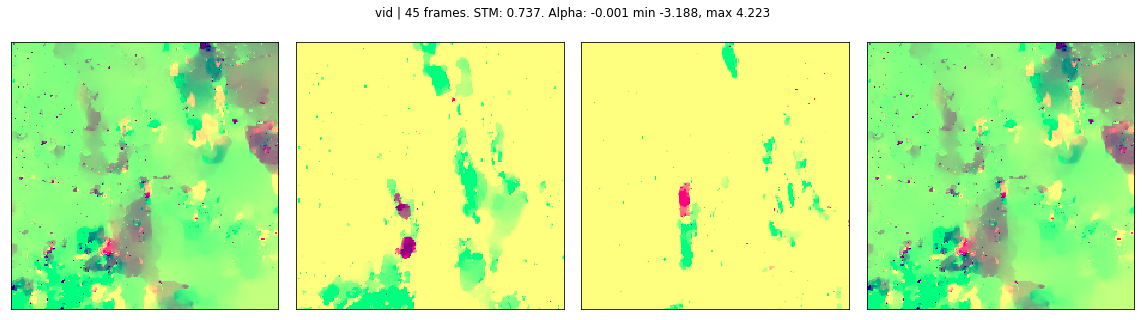

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


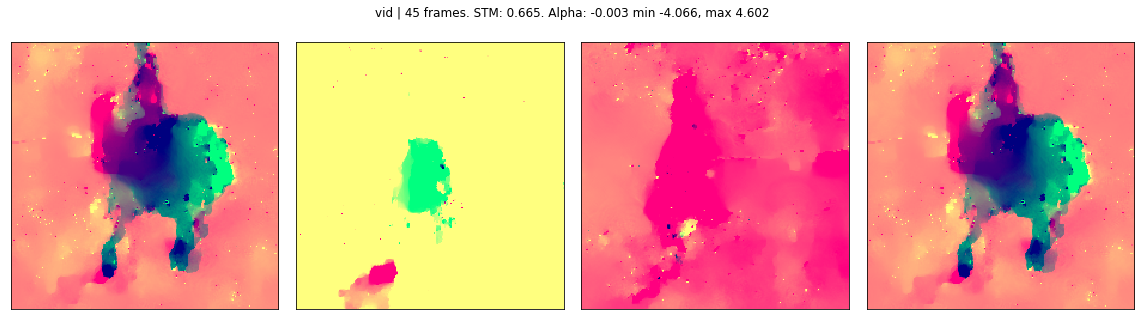

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


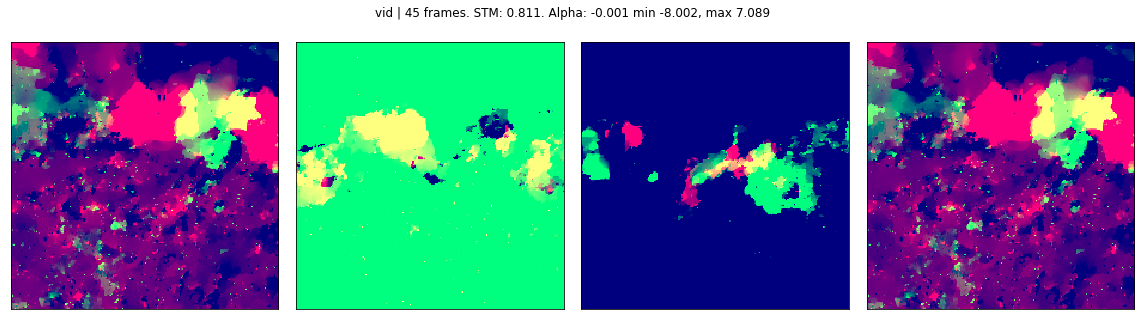

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


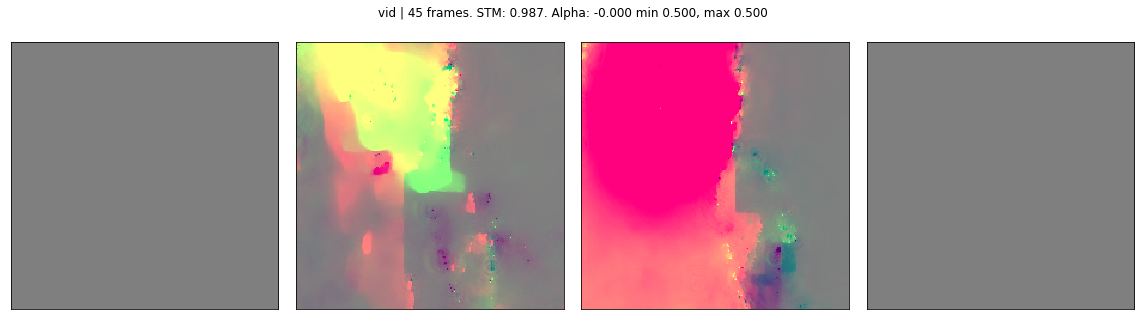

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


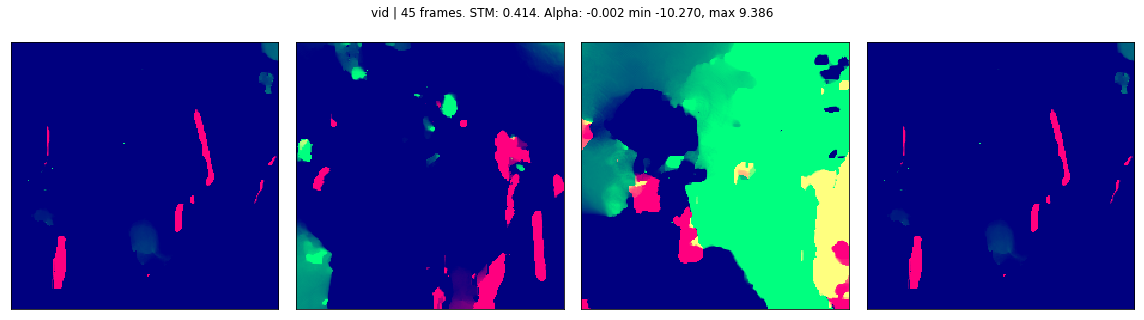

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


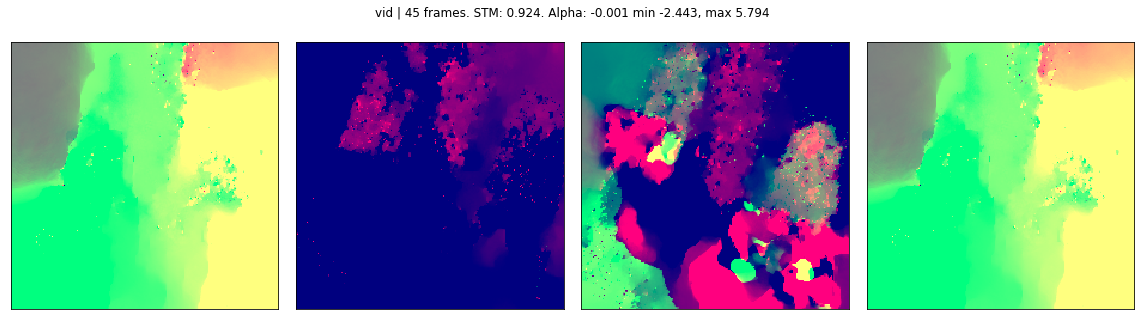

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


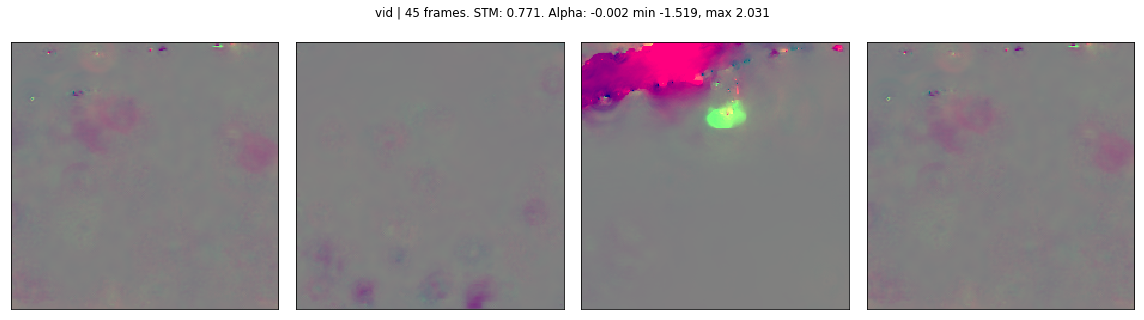

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


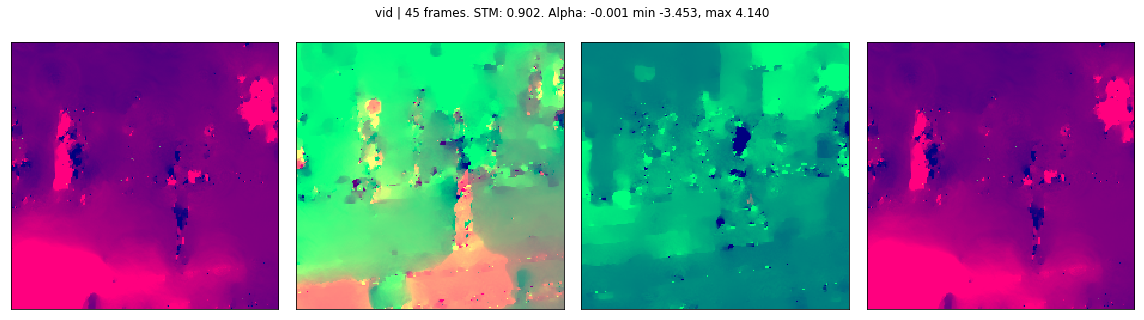

In [53]:
# Choose N videos from memento training

ret = gen_train.__getitem__(np.random.randint(len(gen_train)))

batch=ret[0]
labels=ret[1]

# Display
for i,b in enumerate(batch):
    mem, alpha = labels[i]
    plot_frames(b, 
                title='%s | %d frames. STM: %.3f. Alpha: %.3f' % ('vid',len(b),mem,alpha),
                is_optical_flow=True if data_type=='flow' else False,
                suptitle_y=0.89,
                is_01image=True, 
                frames_to_show=4)

# Model

In [54]:
# Fetching pretrained i3d
i3d = build_model_multigpu(type=data_type, 
                           image_size=cfg._IMAGE_SIZE,
                           num_frames=cfg._NUM_FRAMES, 
                           num_classes=2,
                           gpus=gpus,
                           use_pretrained=True, 
                           verbose=True, 
                           download_weights=True,
                           downsample_factor=None, 
                           dropout_prob=do, 
                           final_activation='tanh', 
                           show_internal_summary=False)
    

Working with single GPU


../src/keras_models.py:763: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  str(input_shape[-1]) + ' input channels.')


x.shape after downsa: (?, 23, 28, 28, 192)
channels_last
x.shape after last conv: (?, 5, 1, 1, 400)
Loading downloaded weights into model: flow_imagenet_and_kinetics from path: /afs/csail.mit.edu/u/v/vcasser/.keras/models/i3d_inception_flow_imagenet_and_kinetics.h5
x.shape before last conv (?, 5, 1, 1, 1024)
x.shape after last conv (?, 5, 1, 1, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 45, 224, 224, 2)   0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 45, 224, 224, 2)   0         
_________________________________________________________________
i3d_inception (Model)        multiple                  12272592  
_________________________________________________________________
Conv3d_6a_1x1_conv (Conv3D)  (None, 5, 1, 1, 2)        2050      
________________________________________________________

In [17]:
%%bash
cd ../ckpt/i3d
ls

memento10k_flow_ep02_valloss8.4081.hdf5
memento10k_flow_ep03_valloss8.4215.hdf5
memento10k_flow_ep03_valloss8.7898.hdf5
memento10k_flow_ep06_valloss8.8485.hdf5
memento10k_flow_ep10_valloss8.5977.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_w0_gpus1_bs8_ep01_valloss499.3931_valrc0.2169.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_w0_gpus1_bs8_ep02_valloss447.0578_valrc0.2386.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_w0_gpus1_bs8_ep03_valloss375.0351_valrc0.2470.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_w0_gpus1_bs8_ep04_valloss283.6391_valrc0.2415.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_w0_gpus1_bs8_ep05_valloss212.9857_valrc0.2394.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_w0_gpus1_bs8_ep06_valloss165.9214_valrc0.2537.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_w0_gpus1_bs8_ep07_valloss139.8545_valrc0.2637.hdf5
memento10k_flow_fznTrue_resc1_ltalphamse_w0_gpus1_bs8_ep01_valloss1543.5431_valrc0.1270.hdf5
memento10k_flow_fznTrue_resc1_ltalphamse_w0_gpus1_bs8_ep01_valloss917.5410_valrc0.15

In [20]:
# Load weights
W = None #'../ckpt/i3d/memento10k_flow_ep06_valloss8.8485.hdf5'
if W:
    i3d.load_weights(W)

In [22]:
# TESTING LOSS
loss = loss_alpha_mse()

for i in range(5):
    ret = gen_train.__getitem__(i)
    batch = ret[0]
    labels = ret[1]
    preds = i3d.predict(batch)
    loss(K.variable(labels), K.variable(preds))

# Train last layers

In [63]:
print('TRAINING WITH %d GPUS'%gpus)

i3d = freeze_unfreeze_net(i3d, gpus, freeze=True)
i3d.summary()


# Define optimizer
lr=0.0001
optimizer = Adam(lr=lr)

print('Compiling model')
a=1
b=10
c=1
# Compile model
i3d.compile(optimizer=optimizer,
              loss=loss_alpha_mse(a,b,c) if loss_type=='alphamse' else loss_alpha,
              metrics=['mse'])
    

ckpt_filepath = get_ckpt_name('../ckpt/i3d', dataset, data_type, True, resc, gpus, bs, loss_type, use_sw, do,a,b,c)
cbs =define_callbacks(ckpt_filepath, gen_val, name_to_mem_alpha, val_names, 
                      lr=lr, drop=0.1, epochs_drop=10, ckpt_period=3)




print('Ready to train last layer')
# Training
i3d.fit_generator(gen_train, 
                  epochs=5,
                  verbose=1,
                  callbacks=cbs, 
                  max_queue_size=30,
                  validation_data=gen_val, 
                  workers=10)



TRAINING WITH 1 GPUS
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 45, 224, 224, 2)   0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 45, 224, 224, 2)   0         
_________________________________________________________________
i3d_inception (Model)        multiple                  12272592  
_________________________________________________________________
Conv3d_6a_1x1_conv (Conv3D)  (None, 5, 1, 1, 2)        2050      
_________________________________________________________________
reshape_4 (Reshape)          (None, 5, 2)              0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 2)                 0         
_________________________________________________________________
prediction (Activation)      (None, 2)                 

# Train full network

In [65]:
print('UNFREEZING')
i3d = freeze_unfreeze_net(i3d, gpus, freeze=False)
i3d.summary()

lr=0.001
optimizer = Adam(lr=lr)

a=1
b=100
c=10
i3d.compile(optimizer=optimizer,
              loss=loss_alpha_mse(a,b,c) if loss_type=='alphamse' else loss_alpha,
              metrics=['mse'])


ckpt_filepath = get_ckpt_name('../ckpt/i3d', dataset, data_type, False, resc, gpus, bs, loss_type, use_sw, do,a,b,c)
cbs =define_callbacks(ckpt_filepath, gen_val, name_to_mem_alpha, val_names, 
                      lr=lr, drop=0.1, epochs_drop=10, ckpt_period=1)


    
print('Ready to train full net')

# Training
i3d.fit_generator(gen_train, 
                  epochs=20,
                  verbose=1, 
                  callbacks=cbs, 
                  max_queue_size=30,
                  validation_data=gen_val, 
                  workers=10)


UNFREEZING
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 45, 224, 224, 2)   0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 45, 224, 224, 2)   0         
_________________________________________________________________
i3d_inception (Model)        multiple                  12272592  
_________________________________________________________________
Conv3d_6a_1x1_conv (Conv3D)  (None, 5, 1, 1, 2)        2050      
_________________________________________________________________
reshape_4 (Reshape)          (None, 5, 2)              0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 2)                 0         
_________________________________________________________________
prediction (Activation)      (None, 2)                 0         

877/878 [============================>.] - ETA: 1s - loss: 4.2975 - mean_squared_error: 0.0024
Total time on this batch: 6.309039708226919  - it: 54000 - idx: 296
Time loading: 4.339182102121413
Time preprocessing: 1.9697736743837595
Time augmenting: 8.393172174692154e-05

Total time on this batch: 3.9287833608686924  - it: 23500 - idx: 92
Time loading: 3.3624954018741846
Time preprocessing: 0.5662834672257304
Time augmenting: 4.491768777370453e-06
878/878 [==============================] - 1043s 1s/step - loss: 4.2978 - mean_squared_error: 0.0024 - val_loss: 6.7558 - val_mean_squared_error: 0.0046
PREDICTING FOR RANK CORRELATION...
188/188 [==============================] - 113s 602ms/step

 --- VAL RANK CORR: 0.50728 --- 



Epoch 00007: saving model to ../ckpt/i3d/memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep07_valloss6.7558_valrc0.5073.hdf5
Epoch 8/20
478/878 [===============>..............] - ETA: 7:07 - loss: 4.2390 - mean_squared_error: 0.0023
Total time

878/878 [==============================] - 1047s 1s/step - loss: 3.3533 - mean_squared_error: 0.0019 - val_loss: 6.6039 - val_mean_squared_error: 0.0045
PREDICTING FOR RANK CORRELATION...
166/188 [=========================>....] - ETA: 13s
Total time on this batch: 3.3360232692211866  - it: 26500 - idx: 171
Time loading: 2.690339676104486
Time preprocessing: 0.6456766733899713
Time augmenting: 6.919726729393005e-06
188/188 [==============================] - 110s 584ms/step

 --- VAL RANK CORR: 0.51991 --- 



Epoch 00014: saving model to ../ckpt/i3d/memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep14_valloss6.6039_valrc0.5199.hdf5
Epoch 15/20
332/878 [==========>...................] - ETA: 9:58 - loss: 3.3568 - mean_squared_error: 0.0020
Total time on this batch: 0.4639885360375047  - it: 60500 - idx: 608
Time loading: 0.3692917227745056
Time preprocessing: 0.09463350847363472
Time augmenting: 6.330478936433792e-05
832/878 [===========================>..] - ETA: 49

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Predict and Evaluate RC

In [ ]:
# Load model if necessary
W = '../ckpt/i3d/memento10k_flow_ep10_valloss11.7493.hdf5'

# i3d.load_weights(W)

In [ ]:
# Predict

preds = i3d.predict_generator(gen_val, verbose=1)

In [ ]:
    pred_mem = [p[0] for p in preds]
    pred_alpha = [p[1] for p in preds]

    true_mem=[]
    true_alpha=[]

    verbose=False

    for i,n in enumerate(val_names[:-3]):
        if verbose:
            print('Name:',n)
            print('True mem:',name_to_mem_alpha[n][0])
            print('Pred mem:',pred_mem[i])
            print('True alpha:',name_to_mem_alpha[n][1])
            print('Pred alpha:',pred_alpha[i])
        true_mem.append(name_to_mem_alpha[n][0])
        true_alpha.append(name_to_mem_alpha[n][1])

    print('First 8 gt mem:', true_mem[:8])
    print('First 8 pred mem:', pred_mem[:8])

    # assert(len(preds)==len(val_names))

    rc = spearmanr(pred_mem, true_mem)
    alpha_rc = spearmanr(pred_alpha, true_alpha)
    

    print('RC:', rc[0])
    print('Alpha_rc:',alpha_rc[0])